# Demonstration Notebook
## Train model to recognize notes from input sounds

By Ben Walsh \
For Liloquy

&copy; 2021 Ben Walsh <ben@liloquy.io>

## Contents

1. [Import Libraries](#lib_import)
2. [Data Import](#data_import)
3. [Data Exploration](#data_explore)
4. [Data Augmentation](#data_aug)
5. [Feature Extraction](#feat_extract)
6. [Save Features](#feat_save)
7. [Train Model](#model_train)
8. [Evaluate Model](#model_eval)
9. [Demo Model](#model_demo)


TO DO
- ---> Debug C/A vs C/E length=2 test
- --> Debug predictions = melody_transcribe currently only using single note
- -->Create a Melody class which inherits Note class for 2+ note
- ->Model registry
- Save features in database instead of csv
- Generalize MUSIC_FPATH in piano_notes
- Generalize training functions to look for any files matching corresponding note tag
  - Add _Male2 recordings
- Submodule repo into simple_gui
- Explore different models - try adding Neural Network
- Feature importance with xgboost
- Optimize hyper-parameters - use gridsearch
- For model selection / parameter optimization, plot train/test errors, consider kfolds
- Make dedicated train.py outside of notebook
- Add model_params in model folder with notes, t_len/hum_len
- Define data_folder and import so hum_wav_file in test model can use it

In [1]:
%load_ext autoreload
%autoreload 2

## <a id = "lib_import"></a>1. Import Libraries

In [2]:
import sys
import os
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import pickle

from scipy.io import wavfile as wav
from IPython.display import Audio

# Add custom modules to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util.music_util import note_to_freq, add_noise, melody_transcribe, melody_write, Note
from util.ml_util import feat_extract, load_training_data


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## <a id = "data_import"></a>2. Data Import

In [3]:
SCALE = ('C4', 'D4', 'E4', 'F4', 'G4', 'A4')
X, y, fs = load_training_data(SCALE)

C:\Users\benja\Documents\Python\note-recognition\util\ml_util.py:83: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wav.read(training_data[note])


## <a id = "data_explore"></a> 3. Data Exploration

### Overview
Sanity check the dimensions of X and y

In [4]:
print('X is a {} with shape {}'.format(type(X), X.shape))
print('X has {} rows, and expected # of rows from notes = {}'.format(X.shape[0], len(SCALE)))
print('X sample length is {}'.format(X.shape[1]))
print('y has {} samples, and expected # of samples from notes = {}'.format(len(y), len(SCALE)))

X is a <class 'numpy.ndarray'> with shape (6, 120000)
X has 6 rows, and expected # of rows from notes = 6
X sample length is 120000
y has 6 samples, and expected # of samples from notes = 6


### Plot Waveform

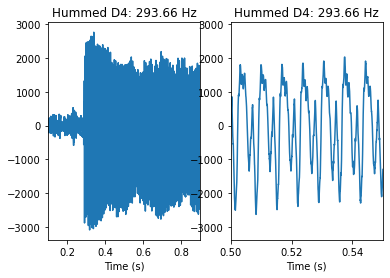

In [5]:
# Pick a note to plot
idx_test = 1
signal_test = X[idx_test,:]
note_test = SCALE[idx_test]

# Create array of time samples, converting number of samples and dividing by sample of frequency 
t_array = np.arange(X.shape[1])/fs

# Plot waveform over short time period to see sine
plt.subplot(121)
plt.xlim(0.1,0.9)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test)

# Plot waveform over shorter time period to see sine
plt.subplot(122)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test)

plt.show()


### Plot Frequency

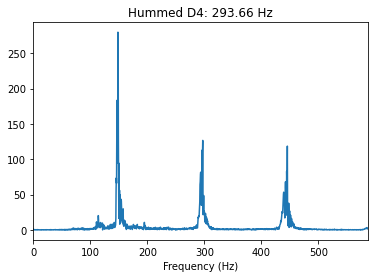

In [6]:
# Take FFT
ftransform = np.fft.fft(signal_test)/len(signal_test)
ftransform = ftransform[range(int(len(signal_test)/2))]
tp_count = len(signal_test)
vals = np.arange(tp_count/2)
t_period = tp_count/fs

# Scale to Hz frequency values for plotting
freqs = vals/t_period

plt.plot(freqs, abs(ftransform))
plt.xlim((0, 2*note_to_freq[note_test]))
plt.xlabel('Frequency (Hz)')
plt.title('Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.show()

## <a id = "data_aug"></a> 4. Data Augmentation 

### Synthesize larger dataset 
Add noise to original recordings

In [7]:
augment_factor = 10
aug_ampl = 100

# Initialize matrix where each row contains a noisy sample
X_aug = np.empty((augment_factor*X.shape[0], X.shape[1]))
y_aug = pd.DataFrame(np.empty((augment_factor*X.shape[0], 1)), columns=['note'])

# Add white noise to each element
for idx in range(X.shape[0]):
    for sample in range(augment_factor):
        X_aug[sample+augment_factor*idx,:] = add_noise(X[idx,:], ampl=aug_ampl)
        y_aug.iloc[sample+augment_factor*idx,0] = SCALE[idx]

Sanity check the dimensions of the augmented training set

In [8]:
print('X_aug has shape {}, with augment_factor = {}'.format(X_aug.shape, augment_factor))
print('Original X has shape {}'.format(X.shape))

X_aug has shape (60, 120000), with augment_factor = 10
Original X has shape (6, 120000)


### Plot example with added noise


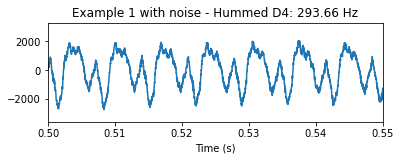

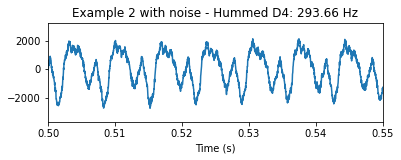

In [9]:
idx_test = 1
signal_test1 = X_aug[idx_test*augment_factor,:]
signal_test2 = X_aug[idx_test*augment_factor+1,:]
note_test = SCALE[idx_test]

# Plot waveform over shorter time period to see sine
plt.subplot(211)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Example 1 with noise - Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test1)

plt.show()

plt.subplot(212)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Example 2 with noise - Hummed {}: {} Hz'.format(note_test, note_to_freq[note_test]))
plt.plot(t_array, signal_test2)

plt.show()

## <a id = "feat_extract"></a> 5. Feature Extraction 

In [10]:
X_feat = feat_extract(X_aug, fs, note_to_freq, SCALE)

In [11]:
X_feat.head()

,C4,D4,E4,F4,G4,A4
0,0.281202,0.138982,0.136890,0.187650,0.216650,0.038625
1,0.286300,0.144791,0.139122,0.185272,0.211724,0.032790
2,0.280549,0.145706,0.136214,0.187127,0.214636,0.035767
3,0.282046,0.148723,0.130994,0.184746,0.214560,0.038931
4,0.285855,0.140443,0.133711,0.180487,0.221542,0.037963


### Explore extracted features

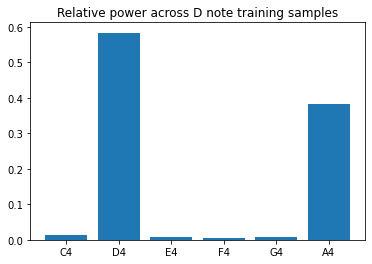

In [12]:
note_test = 'D'
plt.bar(SCALE, X_feat[y_aug['note'].str.contains(note_test)].mean())
plt.title('Relative power across {} note training samples'.format(note_test))
plt.show()

## <a id = "feat_save"></a> 6. Save Features

In [13]:
#import sqlite3
#feat_db = 'test.db'
#table_name = y
#conn = sqlite3.connect(feat_db)
#c = conn.cursor()
#c.execute(f'''CREATE TABLE IF NOT EXISTS {table_name} (
#        id integer PRIMARY KEY,
#        col1 real);''')
#c.execute(f'''INSERT INTO {table_name} (name) VALUES (?)''',(y,))
#conn.close()

Split data for training and testing and save off features

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y_aug, random_state=1)

DATA_FOLDER = r"../data"

if not(os.path.exists(DATA_FOLDER)):
    os.mkdir(DATA_FOLDER)

X_train_file = '../data/X_train.csv'
X_train.to_csv(X_train_file)

X_test.to_csv('../data/X_test.csv')

y_train_file = '../data/y_train.csv'
y_train.to_csv(y_train_file)
y_test.to_csv('../data/y_test.csv')

## <a id = "model_train"></a>7. Train Model

### Define Models

#### SVM model

In [15]:
svm_model = svm.SVC(gamma='scale')

#### XGBoost model

In [16]:
xgb_params = {}
xgb_params['n_estimators'] = 100
xgb_params['max_depth'] = 3
xgb_params['reg_lambda'] = 1

xgb_model = xgb.XGBRegressor(
    n_estimators=xgb_params['n_estimators'],
    reg_lambda=xgb_params['reg_lambda'],
    gamma=0,
    max_depth=xgb_params['max_depth']
)

### Fit Model

In [17]:
svm_model.fit(X_train, y_train)

C:\Users\benja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC()

For XGBoost, categorical labels must be encoded

In [18]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
label_encoded_y = label_encoder.transform(y_train)

In [19]:
xgb_model.fit(X_train, label_encoded_y)

[13:56:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

## <a id = "model_eval"></a>8. Evaluate Model

In [20]:
y_predict_svm = svm_model.predict(X_test)
print(f"Accuracy on test set: {100*accuracy_score(y_test, y_predict_svm)}")

Accuracy on test set: 100.0


In [21]:
y_predict_xgb = xgb_model.predict(X_test)
predictions = [round(value) for value in y_predict_xgb]
# evaluate predictions
print(f"Accuracy on test set: {100*accuracy_score(label_encoder.transform(y_test), predictions)}")

Accuracy on test set: 86.66666666666667


C:\Users\benja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Save Model

In [22]:
MODEL_FOLDER = r"..\model\trained_models"
if not os.path.exists(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)

# Add timestamp to ensure unique name
timestamp = datetime.datetime.now()
timestamp_str = '{}-{:02}-{:02}-{:02}-{}-{}-{}'.format(timestamp.year, timestamp.month, timestamp.day, timestamp.hour, timestamp.minute, timestamp.second, timestamp.microsecond)

pickle.dump(svm_model, open('{}/model-{}'.format(MODEL_FOLDER, timestamp_str), "wb"))

## <a id = "model_demo"></a>9. Demo Model

### Import wav file with pre-recorded hum and play it back

In [24]:
hummed_note = 'C4' 
#hummed_note = 'E4' 
hum_wav_file = fr"C:\Users\benja\OneDrive\Documents\Python\liloquy-git\note-recognition\sound_files\Hum_{hummed_note}.wav"
fs_in, wav_sig_in = wav.read(hum_wav_file)

Audio(hum_wav_file)

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  after removing the cwd from sys.path.


### Predict note with trained model

In [25]:
# Load latest model
os.listdir(MODEL_FOLDER)

['0_model.sav',
 'model-2021-03-16-22-19-47-513746',
 'model-2021-03-18-21-56-14-325856',
 'model-2021-03-18-22-5-47-156863',
 'model-2021-03-20-19-6-46-25954',
 'model-2021-03-26-22-33-58-361456',
 'model-2021-04-11-17-28-47-131661',
 'model-2021-04-24-12-34-51-8516',
 'model-2021-04-24-13-8-0-134219',
 'model-2021-05-20-21-20-32-219595',
 'model-2021-06-02-21-56-38-250136',
 'model-2021-07-10-13-58-18-414298']

In [32]:
# Load latest model
latest_model = os.listdir(MODEL_FOLDER)[-1]
model_to_demo = pickle.load(open('{}/{}'.format(MODEL_FOLDER, latest_model), 'rb'))

hum_len = X.shape[1]
hums = np.empty((1,hum_len))

# Assign test wav file to hums
hums[0,:] = wav_sig_in[:hum_len,1]

X_feat = feat_extract(hums, fs_in, note_to_freq, SCALE)

# Use loaded model to predict note
predictions = model_to_demo.predict(X_feat)
for prediction in predictions:
    # XGBoost outputs are class predictions, so use label_encoder inverse to translate to notes
    if isinstance(model_to_demo, xgb.sklearn.XGBRegressor):
        print(f"Predicted note: {label_encoder.inverse_transform([round(prediction)])}")
    else:
        print('Predicted note: {}'.format(prediction))


Predicted note: C4


### Play back predicted note in piano

In [36]:
# XGBoost outputs are class predictions, so use label_encoder inverse to translate to notes
if isinstance(model_to_demo, xgb.sklearn.XGBRegressor):
    note_predict = Note(note=label_encoder.inverse_transform([round(prediction)])[0])
else:
    note_predict = Note(note=prediction)
note_predict.sound.play(0)

## Predict on length=2 melody 

### Concatenate wav files 

In [42]:
MEL_NOTE_LIST = ('C4','D4')
MEL_FNAME = './melody_test.wav'
mel_sound = melody_write(MEL_NOTE_LIST, fname=MEL_FNAME)
Audio(MEL_FNAME)

### Extract signal and generate note predictions

In [43]:
fs, wav_signal = wav.read(MEL_FNAME)
predictions = melody_transcribe(wav_signal, fs, model_to_demo, hum_len, SCALE) 

In [45]:
# Play back full melody
for pred in predictions:
    
    # XGBoost outputs are class predictions, so use label_encoder inverse to translate to notes
    if isinstance(model_to_demo, xgb.sklearn.XGBRegressor):
        note_predict = Note(note=label_encoder.inverse_transform([round(prediction)])[0])
    else:
        note_predict = Note(note=prediction)
    print("Predicted note: {}".format(note_predict.note))
    note_predict.sound.play(0)
    # Wait before playing the next note
    time.sleep(note_predict.sound.get_length())
    

Predicted note: C4


In [ ]:
# IMPROVEMENT to above
# Create Melody object from Note objects
#melody_predict = Melody(melody=predicted_notes)
#melody_predict.sound.play(1)
